In [1]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold

from scipy.signal import ShortTimeFFT
from scipy.signal.windows import gaussian

#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts

#Pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#Import Braindecode Model EEG Conformer
from braindecode.models import EEGConformer

import gc

/user/home/ko20929/miniconda3/envs/sktime_latest/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package yasa is out of date. Your version is 0.6.3, the latest is 0.6.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
neuro_headset_channels = ["AF3", "F7", "F3", "FC5", "T7", "P7", "O1", "O2", "P8", "T8", "FC6", "F4", "F8", "AF4"]
# These channels are equivalent to the neuro headset channels but for 'our' headset (There is code to generate these in notebook 18) 
eeg_14_channels = ['AF7', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF8'] [:1]

num_channels = len(eeg_14_channels)
num_channels

1

#### Checking model size and batch size

In [3]:
def print_model_size(model):
    # Save the model to a temporary file
    temp_file_path = 'temp_model.pth'
    torch.save(model.state_dict(), temp_file_path)

    # Get the size of the file in bytes
    model_size = os.path.getsize(temp_file_path)

    # Convert bytes to megabytes
    model_size_mb = model_size / (1024 * 1024)

    print(f"Model size: {model_size_mb:.2f} MB")

    # Remove the temporary file
    os.remove(temp_file_path)

In [4]:
print_model_size(model)

NameError: name 'model' is not defined

In [ ]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

In [ ]:
def print_tensor_size_in_gb(tensor):
    # Get the number of elements in the tensor
    num_elements = tensor.numel()
    
    # Get the size of each element in bytes
    element_size = tensor.element_size()
    
    # Calculate the total size in bytes
    total_size_bytes = num_elements * element_size
    
    # Convert bytes to gigabytes
    total_size_gb = total_size_bytes / (1024 ** 3)
    
    print(f"Tensor size: {total_size_gb:.2f} GB")


In [ ]:
print_tensor_size_in_gb(X_train_batch)

In [ ]:
X_train_batch.shape

In [ ]:
30720 / 256

### Running the Conformer Model

In [3]:
# 60 seconds , 2 minutes , 4 minutes?
[60*256 , 2*60*256 , 4*60*256 ] 

[15360, 30720, 61440]

In [4]:
['N1' , 'N2' , 'N3' , 'REM', 'Wake']

['N1', 'N2', 'N3', 'REM', 'Wake']

In [3]:
neuro_headset_channels = ["AF3", "F7", "F3", "FC5", "T7", "P7", "O1", "O2", "P8", "T8", "FC6", "F4", "F8", "AF4"]
# These channels are equivalent to the neuro headset channels but for 'our' headset (There is code to generate these in notebook 18) 
eeg_14_channels = ['AF7', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF8']

num_channels = len(eeg_14_channels)

print(num_channels)

## EEG Conformer code example 
# model = EEGConformer(
#                     n_chans = num_channels,
#                     n_outputs = 2 ,
#                     n_times=segment_length,
#                     att_depth=3,
#                     att_heads=5,
#                     final_fc_length = 'auto' 
#                     )

# df_list = joblib.load('N2' + '_20_channel_normalised_dataframes.pkl')
# df_list_new = [df[eeg_14_channels] for df in df_list]
# joblib.dump(df_list_new, 'N2' + '_14_channel_normalised_dataframes.pkl')

14


In [6]:
# 7.5GB GPU Memory used for the 120 second loop 
# XGB Used for the 60 second loop

In [4]:
#define key parameters for fitting here - will impact GPU memory usage
att_depth=3
att_heads=5
n_chans = num_channels 
batch_size = 8

In [ ]:
array([[-0.69130661, -0.78170604, -0.90790868, ..., -0.38178746,
        -0.38479307, -0.46336862],
       [-0.66731758, -0.62971793, -0.63093751, ..., -0.63983615,
        -0.66769933, -0.67403931],
       [ 0.69386201,  0.44461537,  0.34482799, ...,  0.72146461,
         0.54165871,  0.37065959],
       ...,
       [ 0.03423841, -0.06531218,  0.04377115, ...,  0.78531158,
         0.8674217 ,  0.98879532],
       [-1.38912139, -1.56939274, -1.61677653, ...,  0.12877538,
         0.13982184,  0.22730355],
       [-0.9515577 , -1.08414795, -1.16144004, ...,  0.43103939,
         0.44477925,  0.52224745]])

In [16]:
X.shape
(6027*14*30720) 

2592092160

In [5]:
def test_float32_conversion(arr):
    # Ensure the input array is of type float64
    if arr.dtype != np.float64:
        raise ValueError("Input array must be of type float64.")
    
    # Convert the array to float32
    arr_float32 = arr.astype(np.float32)
    
    # Calculate the absolute and relative differences
    absolute_diff = np.abs(arr - arr_float32)
    relative_diff = np.abs((arr - arr_float32) / arr)
    
    # Summary statistics
    max_abs_diff = np.max(absolute_diff)
    max_rel_diff = np.max(relative_diff)
    mean_abs_diff = np.mean(absolute_diff)
    mean_rel_diff = np.mean(relative_diff)
    
    # Output the differences
    print(f"Max Absolute Difference: {max_abs_diff}")
    print(f"Max Relative Difference: {max_rel_diff}")
    print(f"Mean Absolute Difference: {mean_abs_diff}")
    print(f"Mean Relative Difference: {mean_rel_diff}")
    
    # Determine if the differences are acceptable
    acceptable_threshold = 1e-6  # Define your acceptable threshold
    if max_abs_diff < acceptable_threshold:
        print("Conversion to float32 is likely acceptable.")
    else:
        print("Conversion to float32 may result in significant precision loss.")


In [7]:
test_float32_conversion(X)

MemoryError: Unable to allocate 19.3 GiB for an array with shape (6027, 14, 30720) and data type float64

N2


51.75454831123352

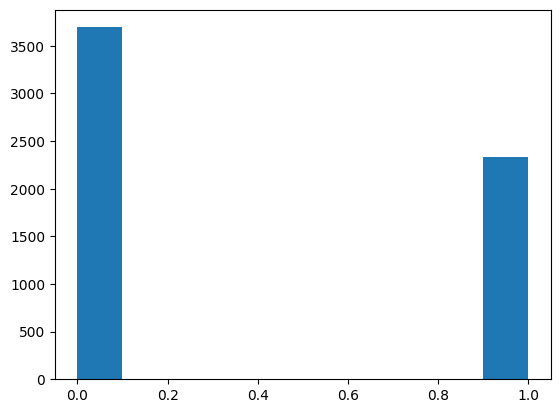

In [6]:
t1 = time.time()

#1.Load the data ________________________________________________________________________________________

# ['Wake', 'N1' , 'N2' , 'N3' , 'REM']

for data_type in ['N2']:
    for segment_length in [30720, 15360]:
    # for segment_length in [15360]:
        
        # if data_type == 'N2':
        #     df_list = joblib.load(data_type + '_14_channel_normalised_dataframes.pkl')
        # else:
        #     df_list = joblib.load(data_type + '_20_channel_normalised_dataframes.pkl')
            
        df_list = joblib.load(data_type + '_20_channel_normalised_dataframes.pkl')
        
        print(data_type)    
        
        # 1. generate all path names and class list(s) etc. 
        folder = '/user/home/ko20929/work/RBD_using_custom_package/Blue_pebble/'
        paths = joblib.load(folder + data_type + '_paths.pkl') # keys : ['selected_paths', 's_class_list', 's_night_list', 's_sleep_type', 's_p_id']
        
        class_label_dict = {'HC': 0 , 'PD' : 1 , 'PD+RBD' : 2 , 'RBD' : 3} #Dictionary used to label the classes for reference
        y = np.array([class_label_dict[c_name] for c_name in paths['s_class_list'] ] )
        groups = paths['s_p_id']
        
        wake_dfs_binary = []
        y_binary = []
        groups_binary = []
        
        for df , class_label , group in zip(df_list, y, groups):
            if class_label in [0,1]:
                wake_dfs_binary.append(df)
                y_binary.append(class_label)
                groups_binary.append(group)
        
        y_binary = np.array(y_binary)
         
        # `df_list` is no longer needed beyond this point so we should free up memory
        del df_list
        gc.collect()
        
    
    #2. Generate 2 second segments of the data______________________________________________________________________ 
    
        #segment_length is user input and overlap is user input at the start of the script
        overlap = 0.5
        
        signal_slices = []
        y_slice_labels = []
        y_slice_groups = []
        
        for df, label, group in zip(wake_dfs_binary, y_binary, groups_binary):
            
            num_segments = int( np.floor(len(df)/segment_length) )
            new_specs = []
            
            for i in np.arange(0,num_segments, 1 - overlap):
                if i > num_segments - 1 :
                    # I don't want it to try to take an incomplete slice
                    # will be an incomplete slice causing errors downstream, needs to stop 
                    
                    break
                  
                start_index = int( np.floor(i*segment_length) )
                end_index = start_index + segment_length
                
                slice_df = df.iloc[start_index : end_index, :].copy()        
                signal_slices.append(slice_df)
                
                y_slice_labels.append(label)
                y_slice_groups.append(group)
                
        plt.hist(y_slice_labels)

        del wake_dfs_binary
        gc.collect()
    
    #3. Select the correct channels ______________________________________________________________________________
        
        channels_selected = eeg_14_channels # will later move this to the top of the notebook
        
        # signal_slices, y_slice_labels, y_slice_groups
        signal_slices_14_channels = [ df.loc[:, channels_selected].copy() for df in signal_slices ]
        
        # Make the slices an np array of the correct dimensions
        signal_slices_14_channels_np = [df.T.values for df in signal_slices_14_channels]
    
    #4. Create the network from the paper (REMOVED as I'm using EEG Conformer) 
    #The model is defined inside the training loop
    
    
    #5. Do Train Validation Splits
        # Train and Validation splits only ----> NO TEST
        # spectrogram_slices, y_slice_labels and y_slice_groups to work with
        train_val_dict = {}
        
        for value in ['train' , 'val']:
            train_val_dict[value] = {}
        
        X = np.stack(signal_slices_14_channels_np)
        y = np.array(y_slice_labels)
        groups = np.array( [int(group) for group in y_slice_groups] )
        break 
        gkf = GroupKFold(n_splits = 4)
        
        
        fold = 0
        
        for train_index, val_index   in gkf.split(X, y, groups*1):
            fold += 1
            
            X_train, y_train, groups_train  = X[train_index], y[train_index] , groups[train_index]
            print('passed previous fail point')
            X_val, y_val, groups_val =  X[val_index], y[val_index] , groups[val_index]   
            
            train_val_dict['train'][fold] = X_train, y_train, groups_train
            train_val_dict['val'][fold]   = X_val, y_val, groups_val
            
            total_len = len(X) 
            val_percent = 100*(len(X_val) / total_len)
            train_percent = 100*(len(X_train) / total_len)
            
            # Commented out the printing here
            # print('fold ' + str(fold) ) 
            # print( str(train_percent)[:3] + ' | '  + str(val_percent)[:3] + ' |' )
        
            # # testing that the splits are as expected
            # print( np.unique(groups_train) )
            # print( np.unique(groups_val) )
            
            # print('__________________________________________________________________________')
        
        #Output from this section of code is X_train, y_train, groups_train AND X_test, y_test, groups_test 
        import time
    
        start_time = time.time()
        
        seeds = [2]
        rows = len(seeds) # Make the figure the right size 
        
        fig = plt.figure()
        fig = plt.figure(figsize=(24,4*rows),dpi=100)
        
        # k is for subplots within the overall figure 
        
        k = 1
        print('Commencing Training ...')
        # Test out for 1 fold to start with
        
        for fold in [1,2,3,4]:
            print(fold)
            X_train, y_train, groups_train = train_val_dict['train'][fold]
            X_val, y_val, groups_val = train_val_dict['val'][fold]  
            
            # Creating train and test data loaders
            train_data = [ (torch.from_numpy(input_slice).float().view(num_channels,segment_length), val) for input_slice, val in zip(X_train, y_train) ] 
            train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
            
            val_data = [ (torch.from_numpy(input_slice).float().view(num_channels,segment_length), val) for input_slice, val in zip(X_val, y_val) ] 
            val_loader = DataLoader(val_data , batch_size=batch_size, shuffle=False)
            
           
            
            
            
            # for seed in [2,5,15,50]:
            for seed in seeds:
                # set all seeds 
                random.seed(seed)
                np.random.seed(seed)
                torch.manual_seed(seed)
                torch.cuda.manual_seed_all(seed) 
                
                device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                # print(device) - to check that device is actually cuda
                
                model = EEGConformer(
                    n_chans = num_channels,
                    n_outputs = 2 ,
                    n_times=segment_length,
                    att_depth=att_depth,
                    att_heads=att_heads,
                    final_fc_length = 'auto' 
                    )
                
                model.to(device)
                
                criterion = torch.nn.NLLLoss()
                optimizer = torch.optim.Adam(model.parameters(), lr = 0.001 )
    
                
                epochs = 35
                train_losses = []
                val_losses = []
                test_losses = []
                
                train_correct = []
                val_correct = []
                test_correct = []
                
                for i in range(epochs):
                    
                    trn_corr = 0
                    val_corr = 0
                    tst_corr = 0
                     
                    
                    trn_loss = 0
                    val_loss = 0
                    tst_loss = 0
                    
                    model.train()
                    # Run the training batches
                    for b, (X_train_batch, y_train_batch) in enumerate(train_loader):
                        # b+=1
                
                        #Move train data to the GPU
                        X_train_batch = X_train_batch.to(device)
                        y_train_batch = y_train_batch.to(device)
                        
                        # Apply the model
                        y_pred = model(X_train_batch)  # we don't flatten X-train here
                        loss = criterion(y_pred, y_train_batch)
                 
                        # Tally the number of correct predictions
                        predicted = torch.argmax(torch.exp( y_pred.detach() ) ,  dim = 1 ) 
        
                        predicted = predicted.reshape(y_train_batch.shape)
                        
                        batch_corr = (predicted == y_train_batch).sum()
                        trn_corr += batch_corr
                        trn_loss += loss.item()
                        
                        # Update parameters
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        
                        
                    train_losses.append(trn_loss)
                    train_correct.append(trn_corr)
                
                    # Run the validation batches
                    # Some of the variables in this loop have the same name as the variables in the above loop... be aware of that plz!
                    model.eval()
                    with torch.no_grad():
                        for b, (X_val_batch, y_val_batch) in enumerate(val_loader):
                            # b+=1
                            
                            #Move train data to the GPU
                            X_val_batch = X_val_batch.to(device)
                            y_val_batch = y_val_batch.to(device)
                
                            # Apply the model
                            y_val = model(X_val_batch)
                
                            # Tally the number of correct predictions
                            predicted = torch.argmax(y_val.detach(),  dim = 1 ) 
                            predicted = predicted.reshape(y_val_batch.shape)
                            
                            batch_corr = (predicted == y_val_batch).sum()
                            val_corr += batch_corr
                
                            loss = criterion(y_val, y_val_batch)
                            val_loss += loss.item()
                           
                    val_losses.append(val_loss)
                    val_correct.append(val_corr)
                
                    
                   
                
                # Plot the outcome from the loop
                
                ax = fig.add_subplot(rows,4,k)
                k+=1
                plt.title('fold ' + str(fold), fontsize = 10)
                plt.plot([(val.cpu() / len(X_train) ) for val in train_correct], label='training set accuracy')
                plt.plot([(val.cpu()/len(X_val) ) for val in val_correct], label='validation set accuracy')
                plt.ylabel('accuracy')
                plt.xlabel('epochs') 
                plt.grid()
            
            
            plt.tight_layout()
        
        
        plt.legend()   
        plt.tight_layout()
        
        #Add text at the bottom of the figure
        # fig.text(0.5, 0, 'This is a caption at the bottom of the figure | Model : ' + str(model) , va='bottom')
        cap_line_2 = '\n' + data_type + '_' + 'Conformer_atth' + str(att_heads) + '_attd' + str(att_depth) + '_' + time_segment + '_secs_' + channels_num + '_channels'
        cap_line_3 = '\n' + str(channels_selected)
        
        fig.text(0.5, 0, f'\nDuration: {time.time() - start_time:.0f} seconds' + ' batch size ' + str(batch_size) +cap_line_2+cap_line_3, ha='center', fontsize=9, va='bottom')
        
        plt.tight_layout(pad = 2.0)
    
        time_segment = str(segment_length/256)
        channels_num = str(num_channels)
         
        # save_name = 'Results/Folder_3/' + data_type + '_' + 'Conformer_window_' + time_segment + '_secs_' + channels_num + '_channels'
        save_name = 'Results/Folder_3/' + data_type + '_' + 'Conformer_atth' + str(att_heads) + '_attd' + str(att_depth) + '_' + time_segment + '_secs_' + channels_num + '_channels'
        
        plt.savefig(save_name +'.png')
        
        
        print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  
        print('Results Saved, on to next data type ...')
        
t2 = time.time()

t2 - t1

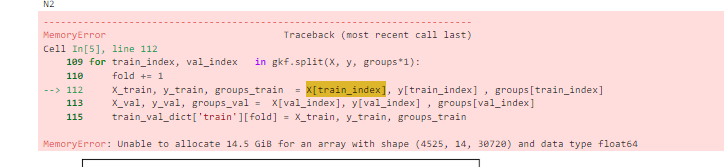

In [ ]:
X_train_batch.shape

Wake 45 seconds took 260 seconds to run <br> 
Then it got an out of memory error --> OutOfMemoryError: CUDA out of memory. Tried to allocate 1.55 GiB. GPU 
